## Using Transfer Learning in Keras to boost accuracy - VGG 16 and Inception V3

### What is Keras and why do we use it?
-- Keras Official Documentation: https://keras.io/
* Higher level deep learning API built on top of TensorFlow (and Theano)
* Well balanced between Expressiveness (e.g. custom designs of architectures) and Flexibility (ease to code)
* Has most state-of-the-art pre-trained models built in its applications, link - https://keras.io/applications/
  - **Xception**
  - **VGG16**
  - **VGG19**
  - **ResNet50**
  - **InceptionV3**
  - **InceptionResNetV2**
  - **MobileNet**
  - **DenseNet**
  - **NASNet**
* Easy to access to above models with few lines of code:
  - <code > from keras.applications.resnet50 import ResNet50 </code>
  - <code > base_model = ResNet50(weights='imagenet', include_top=False, input_shape=[224,224,3]) </code>
* Supports multi-GPU 
* You can win a Kaggle deep learning competition entirely using Keras!

### The common layers to use in Keras. 
* **Core layers** (e.g. Dense, Dropout, Flatten, Reshape)
* **Convolutional Layers** (e.g. Conv2D)
* **Pooling Layers** (e.g. MaxPooling2D, GlobalMaxPooing2D)
* **Recurrent Layers**


## Using Keras - VGG16 to work on the data set

### Import libraries 

In [1]:
import numpy as np 
import os 
import argparse
import sys
from datetime import datetime 
import cv2 

import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

from data_utils import dataset

### Load the data

In [2]:
# download and load data sets
alldata = dataset('/home/weimin/nus/')
alldata.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [3]:
train_data, _, train_labels = alldata.load_training_data()
test_data, _, test_labels = alldata.load_test_data()
class_names = alldata.load_class_names()

Loading data: /home/weimin/nus/cifar-10-batches-py/data_batch_1
Loading data: /home/weimin/nus/cifar-10-batches-py/data_batch_2
Loading data: /home/weimin/nus/cifar-10-batches-py/data_batch_3
Loading data: /home/weimin/nus/cifar-10-batches-py/data_batch_4
Loading data: /home/weimin/nus/cifar-10-batches-py/data_batch_5
Loading data: /home/weimin/nus/cifar-10-batches-py/test_batch
Loading data: /home/weimin/nus/cifar-10-batches-py/batches.meta


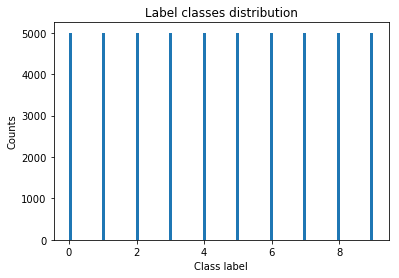

In [4]:
plt.hist(np.where(train_labels)[1], bins = 100)
plt.title('Label classes distribution')
plt.xlabel('Class label')
plt.ylabel('Counts')
plt.show()

### Resize the images - upsize to 48 x 48, which is the minimum dimension accepted by VGG16

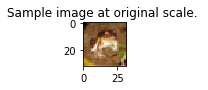

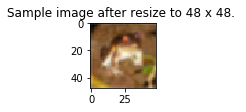

In [5]:
sample_image = train_data[0]

plt.figure(figsize=(sample_image.shape[0]/40,sample_image.shape[1]/40))
plt.title('Sample image at original scale. ')
plt.imshow(sample_image)
plt.show()

sample_image = cv2.resize(sample_image, (48, 48))
plt.figure(figsize=(sample_image.shape[0]/40,sample_image.shape[1]/40))
plt.title('Sample image after resize to 48 x 48. ')
plt.imshow(sample_image)
plt.show()


In [6]:
def resize_images_in_batch(image_arr, new_size):
    
    resize_img_list = []
    for i in range(image_arr.shape[0]):
        img_rgb = image_arr[i]
        img_rgb = cv2.resize(img_rgb, new_size).astype(np.float32)
        
        resize_img_list.append(img_rgb)
    return np.array(resize_img_list)

train_data = resize_images_in_batch(train_data, (48, 48))
test_data = resize_images_in_batch(test_data, (48, 48))

print("Data dimension after resizing: ", train_data.shape)

Data dimension after resizing:  (50000, 48, 48, 3)


### Load the pretrained model, and change the top layers.

### VGG 16 architecture review 

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


In [7]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Reshape, Conv2D, Flatten, MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils

from keras import backend as K

img_w = 48
img_h = 48
img_c = 3 

def getModelVGG():

    K.clear_session()

    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=[img_w, img_h, img_c])

    x = base_model.get_layer('block5_pool').output
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='fc1',kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='fc2',kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(10, activation='sigmoid',kernel_initializer='he_uniform')(x)
    
    model = Model(input=[base_model.input], output=predictions)
    
    mypotim=Adam(lr=0.00008)
    model.compile(loss='categorical_crossentropy',
                  optimizer=mypotim, 
                  metrics=['accuracy'])
    return model

/home/weimin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build the image generator - with image augmentation on the fly

In [8]:
batch_size=64
steps_per_epoch = int(train_data.shape[0] / batch_size)
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 25)

def gen_flow_for_two_inputs(Xi, y):
    genX = gen.flow(Xi,y,batch_size=batch_size,seed=55)
    while True:
        X = genX.next()
        yield X[0], X[1]

### Train the model, and monitor the validation loss and accuracy

In [9]:
model = getModelVGG()

save_model_path = './VGG_Model_Train_Checkpoint.hdf5'
callbacks = [ModelCheckpoint(save_model_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False),
             EarlyStopping(monitor='val_loss', patience=6, verbose=1)]

model.fit_generator(gen_flow_for_two_inputs(train_data,train_labels),
                    steps_per_epoch=steps_per_epoch,
                    shuffle = True, 
                    epochs=10,
                    verbose=1,
                    validation_data = (test_data, test_labels),
                    callbacks=callbacks,
                    initial_epoch=0)

/home/weimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/10
780/781 [============================>.] - ETA: 0s - loss: 1.4177 - acc: 0.4878
Epoch 00001: val_loss improved from inf to 0.81612, saving model to ./VGG_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 53s 68ms/step - loss: 1.4173 - acc: 0.4880 - val_loss: 0.8161 - val_acc: 0.7218
Epoch 2/10
780/781 [============================>.] - ETA: 0s - loss: 0.9411 - acc: 0.6867
Epoch 00002: val_loss improved from 0.81612 to 0.69974, saving model to ./VGG_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 52s 66ms/step - loss: 0.9410 - acc: 0.6867 - val_loss: 0.6997 - val_acc: 0.7605
Epoch 3/10
780/781 [============================>.] - ETA: 0s - loss: 0.7895 - acc: 0.7390
Epoch 00003: val_loss improved from 0.69974 to 0.57080, saving model to ./VGG_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 52s 66ms/step - loss: 0.7895 - acc: 0.7390 - val_loss: 0.5708 - val_acc: 0.8064
Epoch 4/10
780/781 [========================

## Switch to Inception V3 and compare the performance

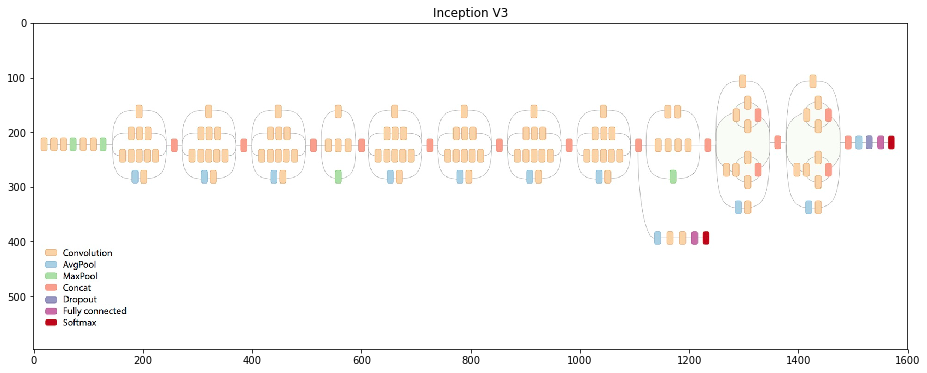

In [43]:
import matplotlib.pyplot 
X = plt.imread('./images/v3.png')
fig=plt.figure(figsize=(140, 6))
plt.imshow(X)
plt.title('Inception V3')
plt.show()

### Define the model

In [11]:
img_w = 139
img_h = 139
img_c = 3 

def getModelV3():

    K.clear_session()

    base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=[img_w, img_h, img_c])

    x = GlobalMaxPooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', name='fc1',kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', name='fc2',kernel_initializer='he_uniform')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(10, activation='sigmoid',kernel_initializer='he_uniform')(x)
    
    model = Model(input=[base_model.input], output=predictions)
    
    mypotim=Adam(lr=0.00008)
    model.compile(loss='categorical_crossentropy',
                  optimizer=mypotim, 
                  metrics=['accuracy'])
    return model

### Resize data

In [12]:
def resize_images_in_batch(image_arr, new_size):
    
    resize_img_list = []
    for i in range(image_arr.shape[0]):
        img_rgb = image_arr[i]
        img_rgb = cv2.resize(img_rgb, new_size).astype(np.float32)
        
        resize_img_list.append(img_rgb)
    return np.array(resize_img_list)

train_data = resize_images_in_batch(train_data, (139, 139))
test_data = resize_images_in_batch(test_data, (139, 139))

print("Data dimension after resizing: ", train_data.shape)

Data dimension after resizing:  (50000, 139, 139, 3)


### Train the model, and monitor the validation loss and accuracy 

In [ ]:
model = getModelV3()

save_model_path = './V3_Model_Train_Checkpoint.hdf5'
callbacks = [ModelCheckpoint(save_model_path, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False),
             EarlyStopping(monitor='val_loss', patience=6, verbose=1)]

model.fit_generator(gen_flow_for_two_inputs(train_data,train_labels),
                    steps_per_epoch=steps_per_epoch,
                    shuffle = True, 
                    epochs=8,
                    verbose=1,
                    validation_data = (test_data, test_labels),
                    callbacks=callbacks,
                    initial_epoch=0)

/home/weimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/15
780/781 [============================>.] - ETA: 0s - loss: 1.6020 - acc: 0.4209
Epoch 00001: val_loss improved from inf to 0.66239, saving model to ./V3_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 182s 234ms/step - loss: 1.6013 - acc: 0.4212 - val_loss: 0.6624 - val_acc: 0.7728
Epoch 2/15
780/781 [============================>.] - ETA: 0s - loss: 0.7739 - acc: 0.7491
Epoch 00002: val_loss improved from 0.66239 to 0.39866, saving model to ./V3_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 172s 220ms/step - loss: 0.7739 - acc: 0.7491 - val_loss: 0.3987 - val_acc: 0.8671
Epoch 3/15
780/781 [============================>.] - ETA: 0s - loss: 0.5759 - acc: 0.8153
Epoch 00003: val_loss improved from 0.39866 to 0.29707, saving model to ./V3_Model_Train_Checkpoint.hdf5
781/781 [==============================] - 172s 220ms/step - loss: 0.5760 - acc: 0.8153 - val_loss: 0.2971 - val_acc: 0.8998
Epoch 4/15
780/781 [=====================

### Make predictions using saved weights

In [13]:
model = getModelV3()

/home/weimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [14]:
save_model_path = './V3_Model_Train_Checkpoint.hdf5'
model.load_weights(save_model_path)

In [20]:
val_preds = model.predict(test_data)
val_preds = np.argmax(val_preds, axis = 1)

In [24]:
print("Predictions accuracy: ", np.sum(val_preds == np.argmax(test_labels, axis =1)) / len(test_labels))

Predictions accuracy:  0.9364
